# Предсказание рейтинга ресторанов Москвы и Санкт-Петербурга

In [1]:
import numpy  as np
import pandas as pd

df_train = pd.read_csv("data/raw/train.csv")

## Обработка

### Дата отзыва (TS)

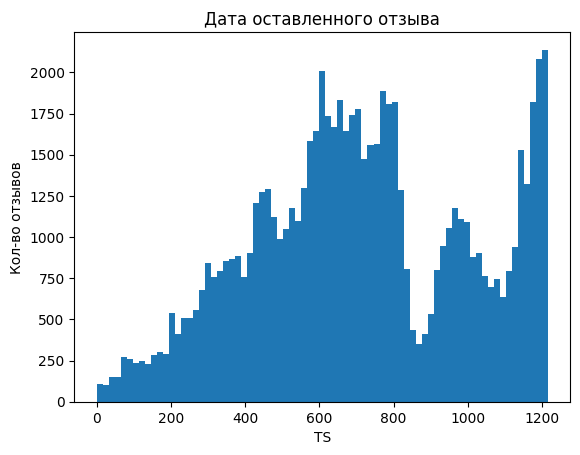

* Доля отзывов после пандемии: 0.36


In [2]:
import matplotlib.pyplot as plt

plt.title("Дата оставленного отзыва")
plt.xlabel("TS")
plt.ylabel("Кол-во отзывов")
plt.hist(df_train["ts"], bins=75)
plt.show()

def percent(df, predicate):
    return round(len(df[predicate]) / len(df), 2)

print(f"* Доля отзывов после пандемии: {percent(df_train, df_train.ts > 800)}")

Можно заметить явный спад около отметки в 800 дней. Зная, что дни отсчитываются с 2018 года, предположим, что это связано с началом пандемии и ограничениями на посещение ресторанов. Преобразуем столбец дней в булевые флаги: отзыв оставлен до или после начала пандемии.

### Локация

Рассмотрим доли отзывов из двух городов, а также ситуацию, когда город клиента не совпадает с городом ресторана.

In [3]:
print(f"* Доля отзывов из Москвы:           {percent(df_train, df_train.user_city == 'msk')}")
print(f"* Доля отзывов из Санкт-Петербурга: {percent(df_train, df_train.user_city == 'spb')}")
print(f"* Доля отзывов с разными городами:  {percent(df_train, df_train.user_city != df_train.org_city)}")

* Доля отзывов из Москвы:           0.72
* Доля отзывов из Санкт-Петербурга: 0.28
* Доля отзывов с разными городами:  0.05


Поскольку доля отзывов с разными городами не велика, будем считать город ресторана приоритетным (т.к. предсказываем средний рейтинг ресторана, а не отзывов пользователя).

### Средний чек

Посмотрим распределение и долю недостающих данных в колонке `average_bill`.

* Доля недостающих данных: 0.39


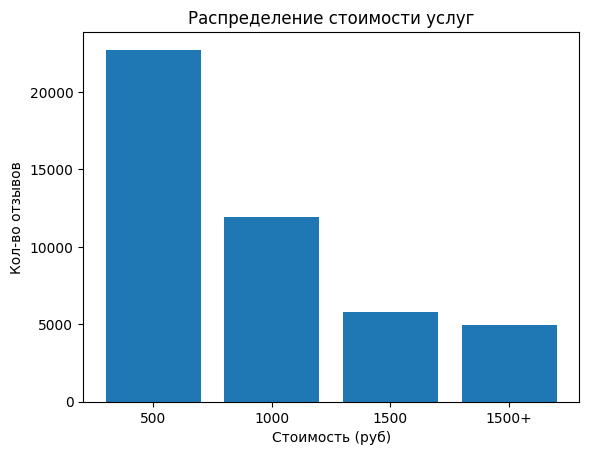

In [4]:
print(f"* Доля недостающих данных: {percent(df_train, df_train.average_bill.isna())}")

bills = df_train["average_bill"].value_counts(bins=[0.001, 500, 1000, 1500, 1e10])
plt.title("Распределение стоимости услуг")
plt.xlabel("Стоимость (руб)")
plt.ylabel("Кол-во отзывов")
plt.bar(["500", "1000", "1500", "1500+"], bills)
plt.show()

Вместо средней стоимости создадим 3 категории по ценам с шагом в 500р.

### Тип заведения

Преобразуем столбец с типом заведений, оценив наиболее популярные категории.

In [5]:
types = df_train.rubrics.value_counts() / len(df_train)
print(f"Доли заведений:")
print(f"* {types.index[0]}:         {types.iloc[0]}")
print(f"* {types.index[1]}:             {types.iloc[1]}")
print(f"* {types.index[2]}:  {types.iloc[2]}")

Доли заведений:
* Ресторан:         0.3574565849043854
* Кафе:             0.25607135617271437
* Быстрое питание:  0.11122373133319818


### Все преобразования

Заменим изначальные признаки на новые, для категориальных применим [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding. Откажемся от признаков, которые встречаются реже 5% отзывов, объединим по смыслу одинаковые из оставшихся.

In [6]:
def format_df(df):
    ### One-hot encoding
    # Date
    df = df.assign(ts_pandemic=lambda a: a["ts"] >= 800)
    df = df.assign(ts_default =lambda a: a["ts"] < 800)
    # Location
    df = df.assign(moscow=lambda a: a["org_city"] == "msk")
    df = df.assign(spb=lambda a:    a["org_city"] == "spb")
    # Avg bill
    df["bill_500"]   = (df["average_bill"] <= 500)
    df["bill_1000"]  = (df["average_bill"] > 500) & (df["average_bill"] <= 1000)
    df["bill_1000+"] = (df["average_bill"] > 1000)
    # Type
    df["type_restourant"] = df["rubrics"] == "Ресторан"
    df["type_kafe"] = df["rubrics"] == "Кафе"
    df["type_others"] = (df["rubrics"] != "Ресторан") & (df["rubrics"] != "Кафе")
    # Tags
    df["accessibility"] = (df["wheelchair_access"] == True) & (df["automatic_door"] == True) & (df["toilet_for_disabled"] == True)
    df["takeaway"] = (df["takeaway"] == True) & (df["online_takeaway"] == True)

    ### Normalization
    # Adjust review weight ([1..5] -> [0..2])
    df.rating = (df.rating - 1) / 2

    ### Exclusion
    # drop all transformed columns
    df = df.drop(columns=["ts", "user_city", "org_city", "average_bill", "rubrics"])
    # drop ids
    df = df.drop(columns=["user_id", "org_id"])
    # drop redundant tags
    drop_tags = [
        # low impact (< 5%)
        'promotions', 'cafe', 'minimum_order', 'free_delivery', 'self_service_kiosks',
        'has_restaurant', 'air_conditioning', 'pets', 'elevator', 'has_bar',
        'internet access', 'privilege_tickets', 'organic_food', 'vip_zone',
        'hall_capacity', 'face_control', 'show_program', 'music', 'chillout',
        'dancefloor', 'dress_code', 'billiards', 'strip', 'elevator_wheelchair_accessible',
        'ramp', 'around_the_clock_work1', 'pickup', 'farm_products', 'delivery',
        'coffee_shop', 'call_button', 'wheelchair_accessible', 'table_games',
        'vinotheque', 'cakes_for_different_occasions', 'accepted_credit_cards',
        'kalyan', 'teahouse', 'bread_from_tandoor', 'handmade_goods',
        # joined
        'wheelchair_access', 'automatic_door', 'toilet_for_disabled',
        'takeaway', 'online_takeaway']
    df = df.drop(columns=drop_tags)
    return df
df_train = format_df(df_train)

## Предсказание

### Построение модели

На лекции предлагается рассматривать количество соседей для алгоритма kNN не больше $\sqrt |D| = 300$.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

def learn_on(train_frame, n=300):
    neigh = KNeighborsRegressor(n_neighbors=n)
    neigh.fit(train_frame.drop(columns=["rating_org"]), train_frame["rating_org"])
    return neigh

train, test = train_test_split(df_train, test_size=0.2, random_state=0)
model3   = learn_on(train, 3)
model300 = learn_on(train, 300)
model = model300

### Оценка модели

* Ошибка предсказания на тренировочных данных (n=3):   0.039737446963190134
* Ошибка предсказания на тренировочных данных (n=300): 0.04517706875443304


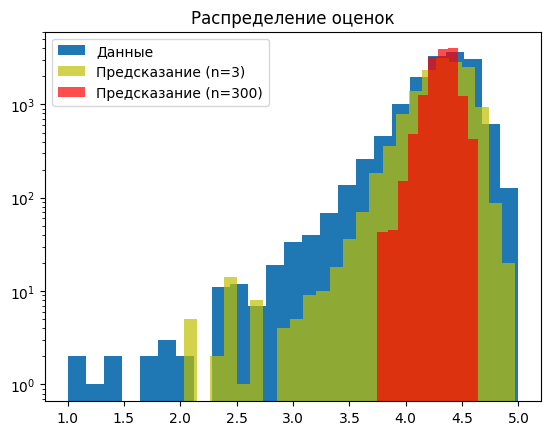

In [8]:
from sklearn.metrics import mean_absolute_percentage_error

prediction3 = model3.predict(test.drop(columns=["rating_org"]))
prediction300 = model300.predict(test.drop(columns=["rating_org"]))
error3 = mean_absolute_percentage_error(test.rating_org, prediction3)
error300 = mean_absolute_percentage_error(test.rating_org, prediction300)
print(f"* Ошибка предсказания на тренировочных данных (n=3):   {error3}")
print(f"* Ошибка предсказания на тренировочных данных (n=300): {error300}")

plt.title("Распределение оценок")
plt.yscale("log")
plt.hist(test["rating_org"], label="Данные", bins=25)
plt.hist(prediction3, label="Предсказание (n=3)", bins=25, alpha=0.7, color="y")
plt.hist(prediction300, label="Предсказание (n=300)", bins=10, alpha=0.7, color="r")
plt.legend(loc="upper left")
plt.show()

### Предсказание модели на тестовых данных

In [9]:
df_test = pd.read_csv("data/raw/test_x.csv")
df_test = format_df(df_test)

test_prediction = model.predict(df_test)
df_test["rating_org"] = test_prediction
df_test.to_csv("data/processed/prediction.csv", columns=["rating_org"], index=True, index_label="id")
print("* Предсказание записано в 'data/processed/prediction.csv'")

* Предсказание записано в 'data/processed/prediction.csv'
